In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
    upsample,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

# Reference scenes rendering

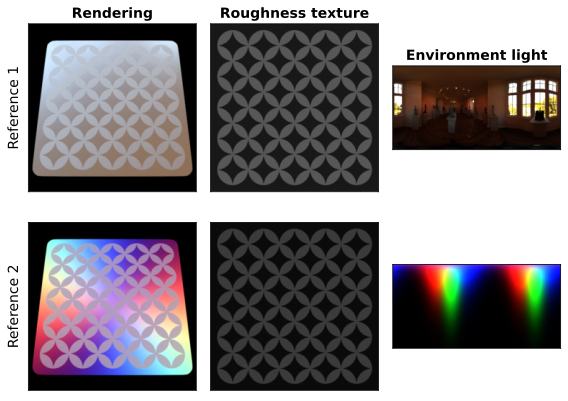

In [2]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=1024) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

refs = {k: {
    "img": image_ref_bm[k],
    "params_rough": params_rough_ref_bm[k],
    "params_envlight": params_envlight_ref_bm[k],
} for k in Scene}

def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

In [3]:
spp_primal = 128
spp = spp_primal
spp_grad = 32

In [4]:
# get reference losses
scene_s1 = reset_scene(Scene.COND1)
image_s1 = mi.render(scene_s1, mi.traverse(scene_s1), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s1 = {k: to_float(LOSS_FNS[k](image_s1, image_ref[Scene.COND1])) for k in LOSS_FNS}

scene_s2 = reset_scene(Scene.COND2)
image_s2 = mi.render(scene_s2, mi.traverse(scene_s2), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s2 = {k: to_float(LOSS_FNS[k](image_s2, image_ref[Scene.COND2])) for k in LOSS_FNS}

In [5]:
ref_loss_s1

{'Relative L1': 0.029033906757831573, 'MSE': 0.0003991394187323749}

In [80]:
def run_opt_rand_init(
    scene_name: Scene,
    upscaling_iter=[{"res": 32, "n_iter": 50}],
    nb_opt_samples=1,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    spp_primal=16,
    spp_grad=4,
    seed=0,
):
    # Optimization parameters
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    images = []
    images_bm = []
    tex_bm = []
    params_end = []

    total_iter = sum([u["n_iter"] for u in upscaling_iter])

    for opt_sample in range(nb_opt_samples):
        losses.append([])
        images.append([])
        images_bm.append([])
        tex_bm.append([])
        params_end.append([])

        # Load scene
        scene = reset_scene(scene_name)

        params = mi.traverse(scene)
        params[ROUGH_KEY] = generate_rand_rough_tex(
            Scene.COND1,
            seed=seed + opt_sample,
            init_res=upscaling_iter[0]["res"],
            opt_res=upscaling_iter[0]["res"],
        )
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[ROUGH_KEY] = params[ROUGH_KEY]
        params.update(opt)

        # initial rendering
        image = mi.render(
            scene,
            params,
            seed=seed + opt_sample,
            spp=spp_primal,
            spp_grad=spp_grad,
        )
        images[opt_sample].append(image)
        images_bm[opt_sample].append(image_to_bm(image))
        tex_bm[opt_sample].append(unidim_to_bm(params[ROUGH_KEY]))

        it = 1
        n_iter = 0
        for upscaling in upscaling_iter:
            params[ROUGH_KEY] = upsample(params[ROUGH_KEY], upscaling["res"])
            opt[ROUGH_KEY] = params[ROUGH_KEY]
            params.update(opt)

            n_iter += upscaling["n_iter"]
            while it <= n_iter:
                # Render
                image = mi.render(
                    scene,
                    params,
                    seed=seed + opt_sample * total_iter + it,
                    spp=spp_primal,
                    spp_grad=spp_grad,
                )

                # Apply loss function
                loss = loss_fn(image, image_ref[scene_name])

                # Backpropagate
                dr.backward(loss)

                # Optimizer: take a gradient step
                opt.step()
                opt[ROUGH_KEY] = dr.clamp(opt[ROUGH_KEY], 1e-2, 1.0)

                # Optimizer: Update the scene parameters
                params.update(opt)

                if it == total_iter:
                    params_end[opt_sample].append(params[ROUGH_KEY])

                print(
                    f"[Sample {opt_sample+1}/{nb_opt_samples}] [res {upscaling['res']}]"
                    f" [iter {it - (n_iter - upscaling['n_iter'])}/{upscaling['n_iter']}] loss: {loss[0]:.5f}",
                    end="\r",
                )
                losses[opt_sample].append(loss[0])

                it += 1

            images[opt_sample].append(image)
            images_bm[opt_sample].append(image_to_bm(image))
            tex_bm[opt_sample].append(unidim_to_bm(params[ROUGH_KEY]))

            print()

    return {
        "losses": losses,
        "images": images,
        "images_bm": images_bm,
        "tex_bm": tex_bm,
        "params_end": params_end,
    }

In [48]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Roughness texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

# Several runs

In [81]:
res = run_opt_rand_init(
    scene_name = Scene.COND1,
    upscaling_iter=[{"res":4,"n_iter":10}, {"res":8,"n_iter":20}, {"res":16,"n_iter":50}, {"res":32,"n_iter":50}, {"res":128,"n_iter":50}, {"res":512,"n_iter":50}],
    nb_opt_samples=5,
    optimizer_name="adam",
    lr=5e-3,
    loss_fn=mse,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

[Sample 1/5] [res 4] [iter 10/10] loss: 0.00685
[Sample 1/5] [res 8] [iter 20/20] loss: 0.00502
[Sample 1/5] [res 16] [iter 50/50] loss: 0.00312
[Sample 1/5] [res 32] [iter 50/50] loss: 0.00158
[Sample 1/5] [res 128] [iter 50/50] loss: 0.00052
[Sample 1/5] [res 512] [iter 50/50] loss: 0.00040
[Sample 2/5] [res 4] [iter 10/10] loss: 0.00564
[Sample 2/5] [res 8] [iter 20/20] loss: 0.00417
[Sample 2/5] [res 16] [iter 50/50] loss: 0.00280
[Sample 2/5] [res 32] [iter 50/50] loss: 0.00144
[Sample 2/5] [res 128] [iter 50/50] loss: 0.00053
[Sample 2/5] [res 512] [iter 50/50] loss: 0.00044
[Sample 3/5] [res 4] [iter 10/10] loss: 0.00523
[Sample 3/5] [res 8] [iter 20/20] loss: 0.00424
[Sample 3/5] [res 16] [iter 50/50] loss: 0.00282
[Sample 3/5] [res 32] [iter 50/50] loss: 0.00143
[Sample 3/5] [res 128] [iter 50/50] loss: 0.00052
[Sample 3/5] [res 512] [iter 50/50] loss: 0.00043
[Sample 4/5] [res 4] [iter 10/10] loss: 0.00595
[Sample 4/5] [res 8] [iter 20/20] loss: 0.00431
[Sample 4/5] [res 16] 

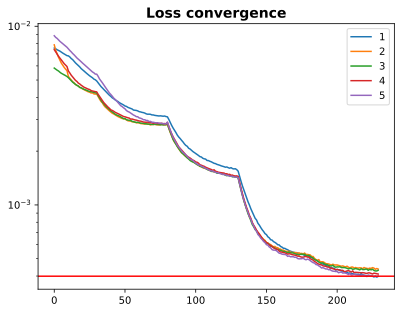

In [110]:
plot_losses(res["losses"], baseline=ref_loss_s1["MSE"])

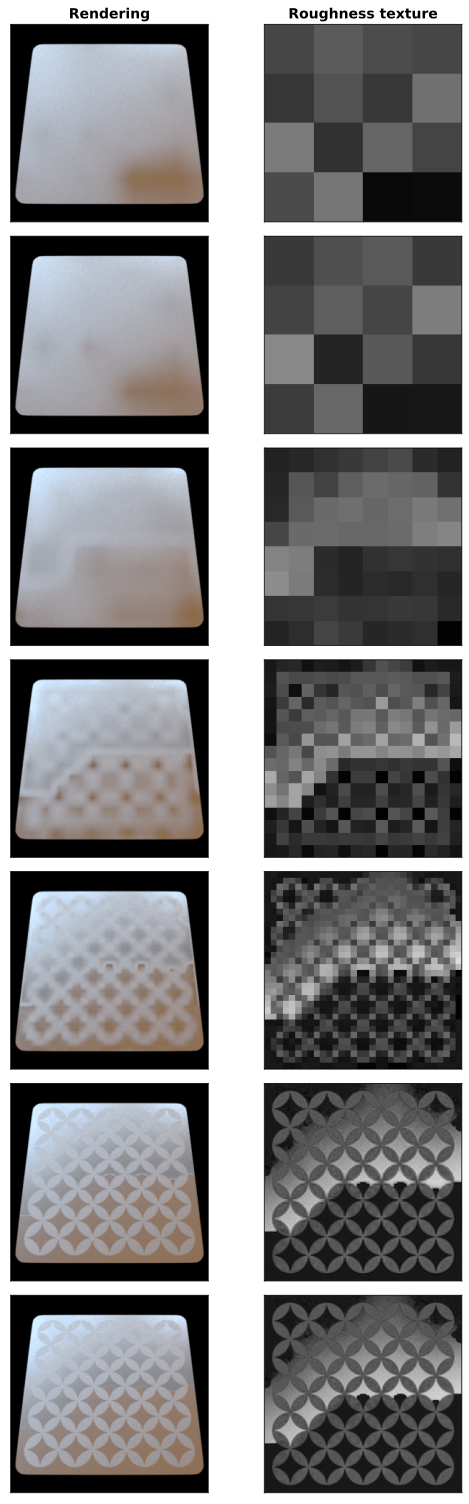

In [83]:
plot(res["images_bm"][0], res["tex_bm"][0], size_factor=3)

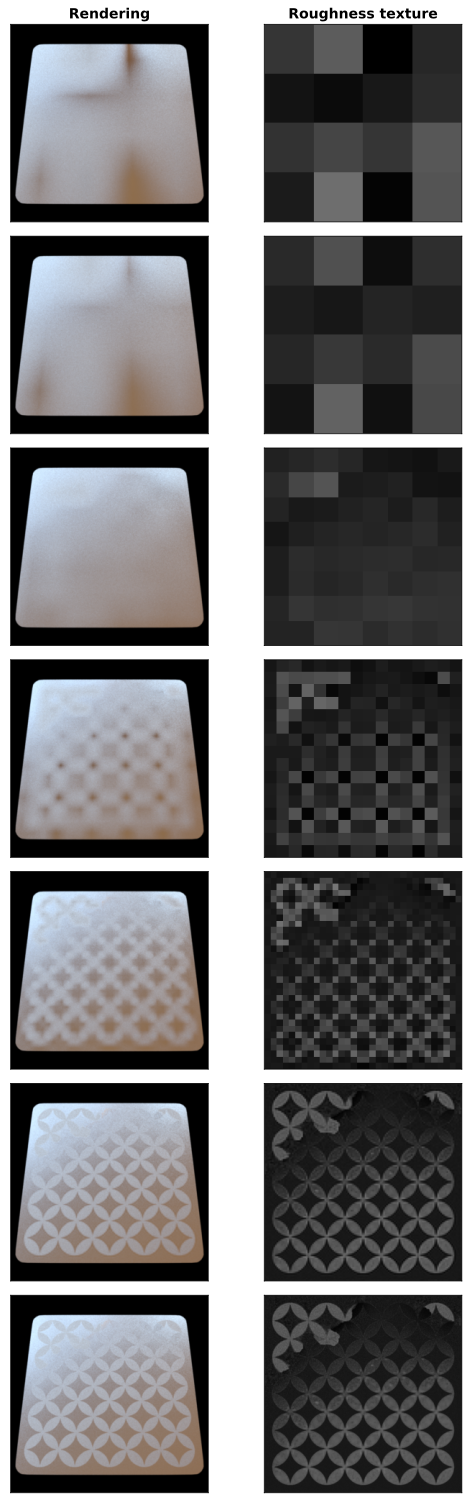

In [84]:
plot(res["images_bm"][1], res["tex_bm"][1], size_factor=3)

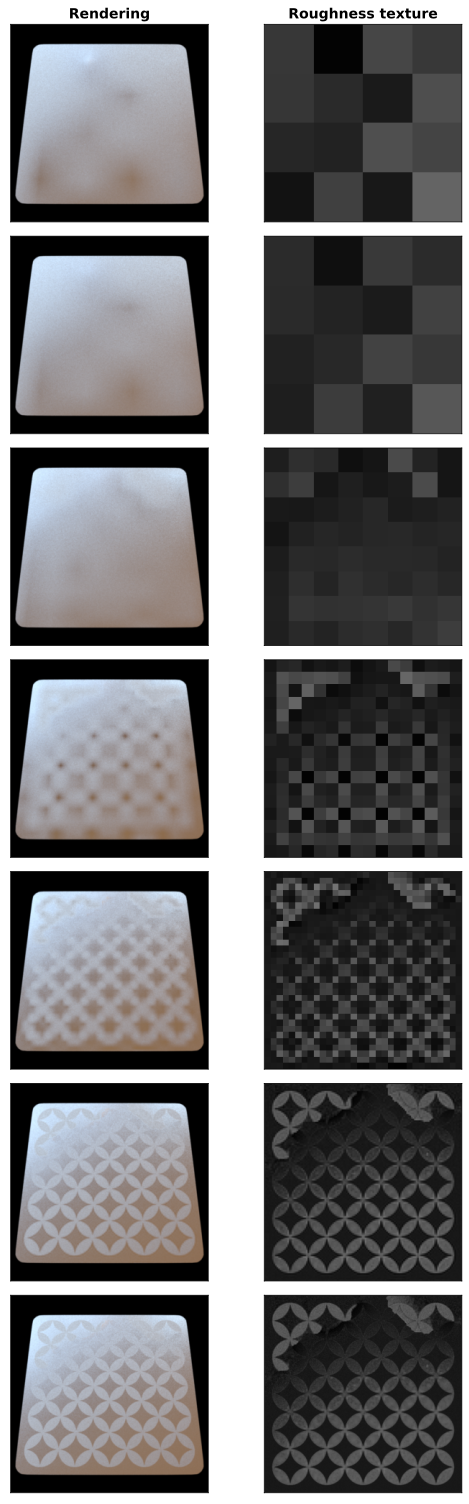

In [85]:
plot(res["images_bm"][2], res["tex_bm"][2], size_factor=3)

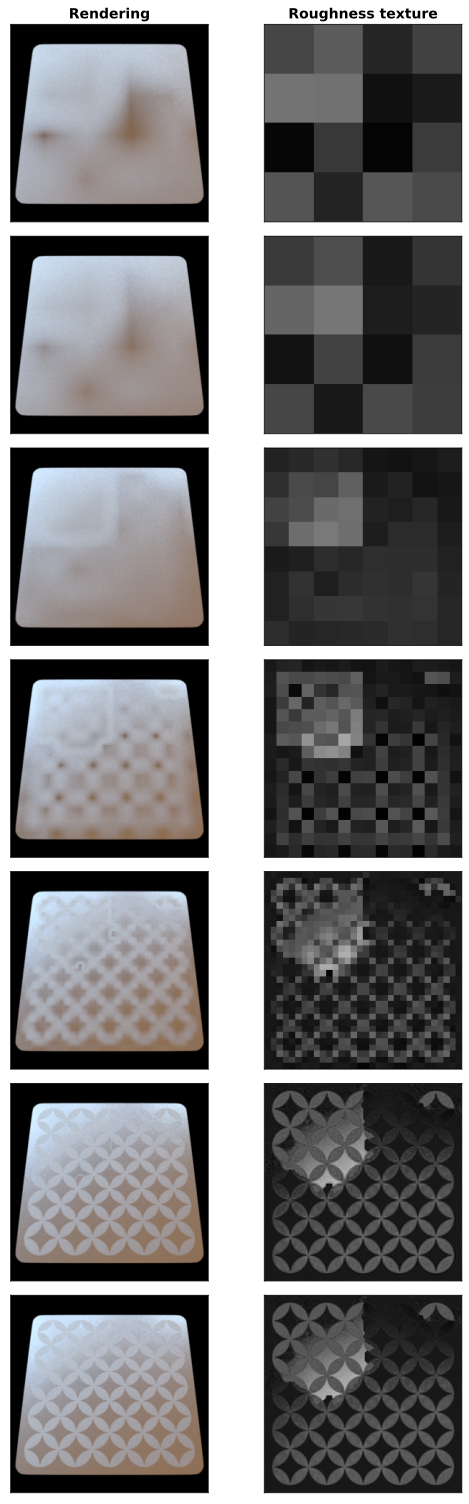

In [86]:
plot(res["images_bm"][3], res["tex_bm"][3], size_factor=3)

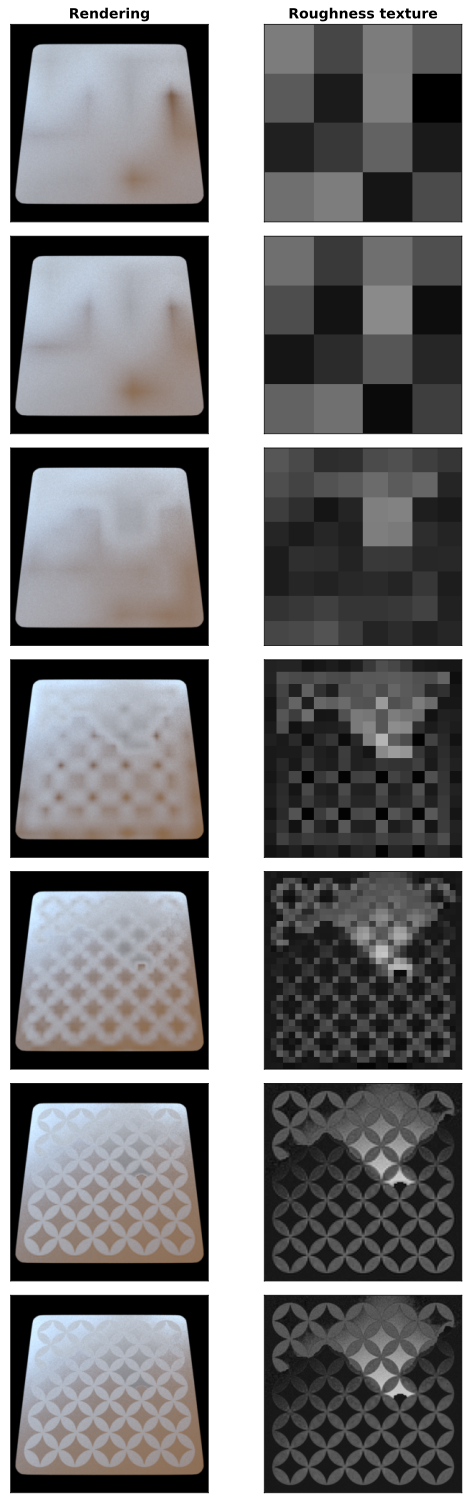

In [87]:
plot(res["images_bm"][4], res["tex_bm"][4], size_factor=3)

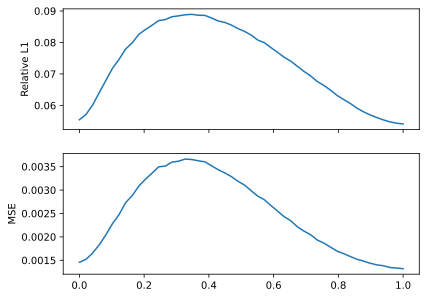

In [88]:
params_1 = {ROUGH_KEY: params_rough_ref[Scene.COND1]}
params_2 = {ROUGH_KEY: res["params_end"][0][0]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

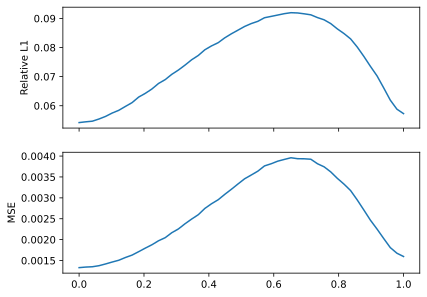

In [90]:
params_1 = {ROUGH_KEY: res["params_end"][0][0]}
params_2 = {ROUGH_KEY: res["params_end"][1][0]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

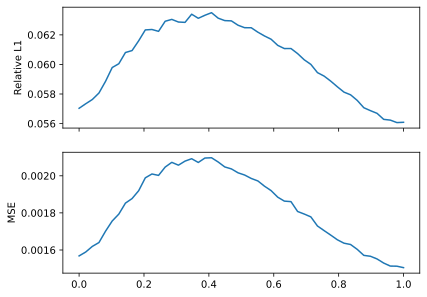

In [91]:
params_1 = {ROUGH_KEY: res["params_end"][2][0]}
params_2 = {ROUGH_KEY: res["params_end"][3][0]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

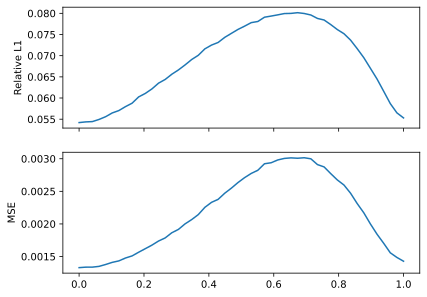

In [92]:
params_1 = {ROUGH_KEY: res["params_end"][0][0]}
params_2 = {ROUGH_KEY: res["params_end"][4][0]}
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_scene_func=lambda: reset_scene(Scene.COND1))

In [101]:
print(mse(image_ref[Scene.COND1], image_s1))
print(np.sum((image_s1 - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((image_s1 - image_ref[Scene.COND1])**2, axis=2))

[0.0003991394187323749]
313.896


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [102]:
print(mse(image_ref[Scene.COND1], res["images"][0][-1]))
print(np.sum((res["images"][0][-1] - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((res["images"][0][-1] - image_ref[Scene.COND1])**2, axis=2))

[0.00039911569911055267]
313.87735


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [103]:
print(mse(image_ref[Scene.COND1], res["images"][1][-1]))
print(np.sum((res["images"][1][-1] - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((res["images"][1][-1] - image_ref[Scene.COND1])**2, axis=2))

[0.000437331385910511]
343.93137


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [104]:
print(mse(image_ref[Scene.COND1], res["images"][2][-1]))
print(np.sum((res["images"][2][-1] - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((res["images"][2][-1] - image_ref[Scene.COND1])**2, axis=2))

[0.0004308139905333519]
338.806


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [105]:
print(mse(image_ref[Scene.COND1], res["images"][3][-1]))
print(np.sum((res["images"][3][-1] - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((res["images"][3][-1] - image_ref[Scene.COND1])**2, axis=2))

[0.0004103280953131616]
322.69513


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [106]:
print(mse(image_ref[Scene.COND1], res["images"][4][-1]))
print(np.sum((res["images"][4][-1] - image_ref[Scene.COND1])**2))
unidim_to_bm(5*np.sum((res["images"][4][-1] - image_ref[Scene.COND1])**2, axis=2))

[0.0003982410707976669]
313.18945


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 0,
  struct = Struct<3>[
    uint8 R; // @0, normalized, premultiplied alpha
    uint8 G; // @1, normalized, premultiplied alpha
    uint8 B; // @2, normalized, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]